In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer


from statsmodels.tsa.stattools import adfuller, kpss

In [5]:
# Load the processed data
train_datarf = pd.read_csv('../Data/output/train_data.csv')
test_datarf = pd.read_csv('../Data/output/test_data.csv')
validation_datarf = pd.read_csv('../Data/output/validation_data.csv')

train_datarf['Date'] = pd.to_datetime(train_datarf['Date'])
test_datarf['Date'] = pd.to_datetime(test_datarf['Date'])
validation_datarf['Date'] = pd.to_datetime(validation_datarf['Date'])

train_datarf.set_index(train_datarf.columns[0], inplace=True)
test_datarf.set_index(test_datarf.columns[0], inplace=True)
validation_datarf.set_index(validation_datarf.columns[0], inplace=True)


In [6]:
# Separating target variable and features
y_train = train_datarf['log_return']
X_train = train_datarf.drop(['log_return'], axis=1)

y_test = test_datarf['log_return']
X_test = test_datarf.drop(['log_return'], axis=1)

y_validation = validation_datarf['log_return']
X_validation = validation_datarf.drop(['log_return'], axis=1)

In [7]:
# Initialize the Random Forest Regressor with a random state for reproducibility
random_forest = RandomForestRegressor(random_state=42)

# Fit the model to the training data
random_forest.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [8]:
# Predict on the training data
y_train_pred = random_forest.predict(X_train)

# Predict on the testing data
y_test_pred = random_forest.predict(X_test)

# Predict on the testing data
y_validation_pred = random_forest.predict(X_validation)

In [9]:
# Calculate performance metrics on the training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)



In [10]:
# Calculate performance metrics on the testing data
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


In [11]:
# Calculate performance metrics on the validation data
validation_mse = mean_squared_error(y_validation, y_validation_pred)
validation_mae = mean_absolute_error(y_validation, y_validation_pred)
validation_r2 = r2_score(y_validation, y_validation_pred)


In [12]:
# Display the results

print("Training data")
print("MSE:", train_mse)
print("MAE:", train_mae)
print("R2:", train_r2)
print()


print("Testing data")
print("MSE:", test_mse)
print("MAE:", test_mae)
print("R2:", test_r2)
print()

print("Validation data")
print("MSE:", validation_mse)
print("MAE:", validation_mae)
print("R2:", validation_r2)

Training data
MSE: 0.005557404601910226
MAE: 0.030572236128369474
R2: 0.9944425953980898

Testing data
MSE: 0.013589009378488778
MAE: 0.061380550604533596
R2: 0.9739185655921504

Validation data
MSE: 0.06034594719112632
MAE: 0.07277282392172701
R2: 0.9258607297530387


In [13]:
# Initialize the Random Forest Regressor
random_forest_baseline = RandomForestRegressor(random_state=42)

# Create a time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation
cv_scores = cross_val_score(random_forest_baseline, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

# Convert scores to positive (since they are negative MSE)
cv_scores = -cv_scores

# Calculate mean and standard deviation of the scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"Cross-Validation Scores (MSE): {cv_scores}")
print(f"Mean CV Score (MSE): {mean_cv_score}")
print(f"Standard Deviation of CV Score: {std_cv_score}")


Cross-Validation Scores (MSE): [0.70267348 0.98136848 0.12328738 0.03092246 0.02176187]
Mean CV Score (MSE): 0.37200273309238885
Standard Deviation of CV Score: 0.39535641981619635


In [14]:
# Fit the Random Forest model
random_forest_baseline.fit(X_train, y_train)

# Get feature importances
feature_importances = random_forest_baseline.feature_importances_

# Create a DataFrame to display feature importances

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features_df)


                Feature  Importance
4    Closing_Price_Diff    0.862263
19             BB_lower    0.013464
3         24h Low (USD)    0.010852
32                lag_2    0.008299
0   Closing Price (USD)    0.006836
33                lag_3    0.006145
15     7_day_volatility    0.006109
12              WMA_100    0.005814
17             BB_upper    0.005644
8               EMA_100    0.004432
1        24h Open (USD)    0.004323
9                 WMA_7    0.004023
11               WMA_50    0.003916
31                lag_1    0.003843
24              Stoch_k    0.003474
30                  ROC    0.003400
20                  RSI    0.003397
2        24h High (USD)    0.003341
26      Ichimoku_Span_A    0.003132
27      Ichimoku_Span_B    0.003071
34              day_sin    0.002966
7                EMA_50    0.002690
18            BB_middle    0.002424
5                 EMA_7    0.002409
16    30_day_volatility    0.002309
28  14_day_rolling_mean    0.002234
13           WMA7_WMA20    0

In [15]:
# Initialize RFECV with Random Forest
selector = RFECV(estimator=RandomForestRegressor(random_state=42), step=1, cv=tscv, scoring='neg_mean_squared_error')

# Fit RFECV to the training data
selector.fit(X_train, y_train)


RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
      estimator=RandomForestRegressor(random_state=42),
      scoring='neg_mean_squared_error')

In [16]:
# Transform the datasets based on selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
X_validation_selected = selector.transform(X_validation)

# Fit the model to the selected training features
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train_selected, y_train)

RandomForestRegressor(random_state=42)

In [17]:
# Predict and calculate performance metrics
y_train_pred = random_forest.predict(X_train_selected)
y_test_pred = random_forest.predict(X_test_selected)
y_validation_pred = random_forest.predict(X_validation_selected)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
validation_mse = mean_squared_error(y_validation, y_validation_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
validation_mae = mean_absolute_error(y_validation, y_validation_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
validation_r2 = r2_score(y_validation, y_validation_pred)



In [18]:
# Display the results

print("Training data")
print("MSE:", train_mse)
print("MAE:", train_mae)
print("R2:", train_r2)
print()


print("Testing data")
print("MSE:", test_mse)
print("MAE:", test_mae)
print("R2:", test_r2)
print()

print("Validation data")
print("MSE:", validation_mse)
print("MAE:", validation_mae)
print("R2:", validation_r2)


Training data
MSE: 0.003571001869228364
MAE: 0.023160084665869298
R2: 0.9964289981307717

Testing data
MSE: 0.007399842439471581
MAE: 0.0365285326137316
R2: 0.9857974558823239

Validation data
MSE: 0.03292322036979196
MAE: 0.050075142121163714
R2: 0.9595514919226391


In [22]:
# Initialize the Random Forest Regressor
random_forest = RandomForestRegressor(random_state=42)

# Define your cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation for MSE
mse_scores = cross_val_score(random_forest, X_train_selected, y_train, cv=tscv, scoring=make_scorer(mean_squared_error))
mean_mse = mse_scores.mean()

# Perform cross-validation for MAE
mae_scores = cross_val_score(random_forest, X_train_selected, y_train, cv=tscv, scoring=make_scorer(mean_absolute_error))
mean_mae = mae_scores.mean()

# Perform cross-validation for R2
r2_scores = cross_val_score(random_forest, X_train_selected, y_train, cv=tscv, scoring=make_scorer(r2_score))
mean_r2 = r2_scores.mean()

# Print the results
print(f"Cross-Validated MSE: {mean_mse}")
print(f"Cross-Validated MAE: {mean_mae}")
print(f"Cross-Validated R2: {mean_r2}")


Cross-Validated MSE: 0.324835042319996
Cross-Validated MAE: 0.30506118520073705
Cross-Validated R2: 0.7258581683074763


In [23]:
# Parameters grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit Grid Search to the data with selected features
grid_search.fit(X_train_selected, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train a new model with the best parameters
optimized_random_forest = RandomForestRegressor(**best_params)
optimized_random_forest.fit(X_train_selected, y_train)


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=300)

In [24]:
# Retrain the model with the best parameters
optimized_random_forest = RandomForestRegressor(
    max_depth=10, 
    min_samples_leaf=2, 
    min_samples_split=2, 
    n_estimators=300,
    random_state=42
)

optimized_random_forest.fit(X_train_selected, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)

In [25]:
# Evaluate on training data
y_train_pred = optimized_random_forest.predict(X_train_selected)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate on testing data
y_test_pred = optimized_random_forest.predict(X_test_selected)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Evaluate on validation data
y_validation_pred = optimized_random_forest.predict(X_validation_selected)
validation_mse = mean_squared_error(y_validation, y_validation_pred)
validation_mae = mean_absolute_error(y_validation, y_validation_pred)
validation_r2 = r2_score(y_validation, y_validation_pred)

# Print the results
print("Training MSE:", train_mse, "MAE:", train_mae, "R2:", train_r2)
print("Testing MSE:", test_mse, "MAE:", test_mae, "R2:", test_r2)
print("Validation MSE:", validation_mse, "MAE:", validation_mae, "R2:", validation_r2)


Training MSE: 0.008799070128195674 MAE: 0.032186478517081854 R2: 0.9912009298718043
Testing MSE: 0.007226724646825972 MAE: 0.03625022667339131 R2: 0.9861297214822629
Validation MSE: 0.04794953824361022 MAE: 0.05181337064919493 R2: 0.9410905961455723


In [26]:
# Assuming you have a variable `optimized_random_forest` for your tuned model
scores = cross_val_score(optimized_random_forest, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')

# Cross-validation for Mean Absolute Error
mae_scores = cross_val_score(optimized_random_forest, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
mean_mae = -mae_scores.mean()  # Negating to get positive values

# Cross-validation for Mean Absolute Error
mae_scores = cross_val_score(optimized_random_forest, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
mean_mae = -mae_scores.mean()  # Negating to get positive values

# Cross-validation for R2 Score
r2_scores = cross_val_score(optimized_random_forest, X_train_selected, y_train, cv=5, scoring='r2')
mean_r2 = r2_scores.mean()


print("Cross-validated Mean Absolute Error (MAE):", mean_mae)
print("Cross-validated MSE:", -scores.mean())
print("Cross-validated R-squared (R2):", mean_r2)


Cross-validated Mean Absolute Error (MAE): 0.1232127591220159
Cross-validated MSE: 0.07932680157827049
Cross-validated R-squared (R2): 0.9212618641842759


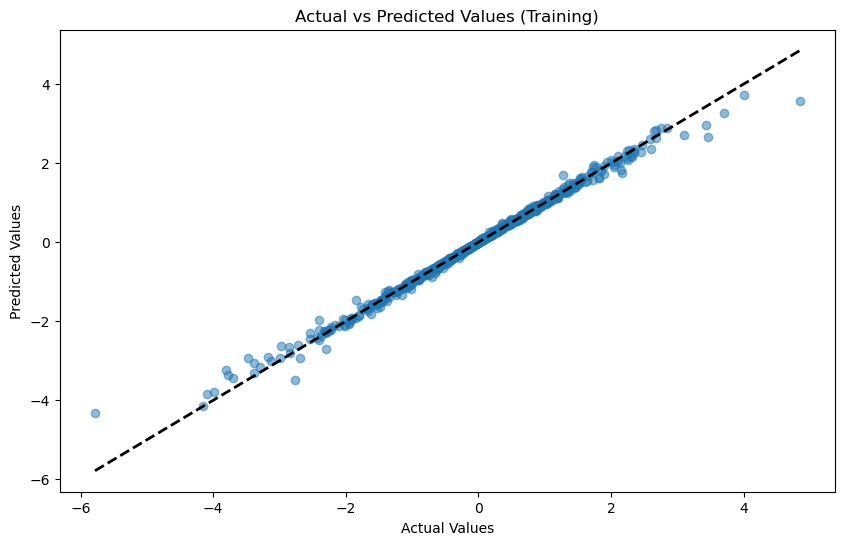

In [39]:
#Plotting of training data

plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Training)')
plt.show()


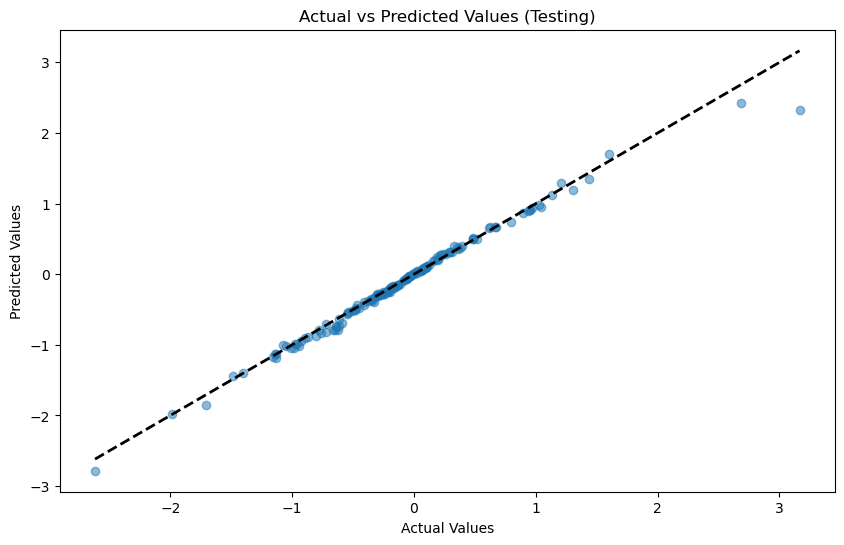

In [33]:
#Plotting of training data

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Testing)')
plt.show()


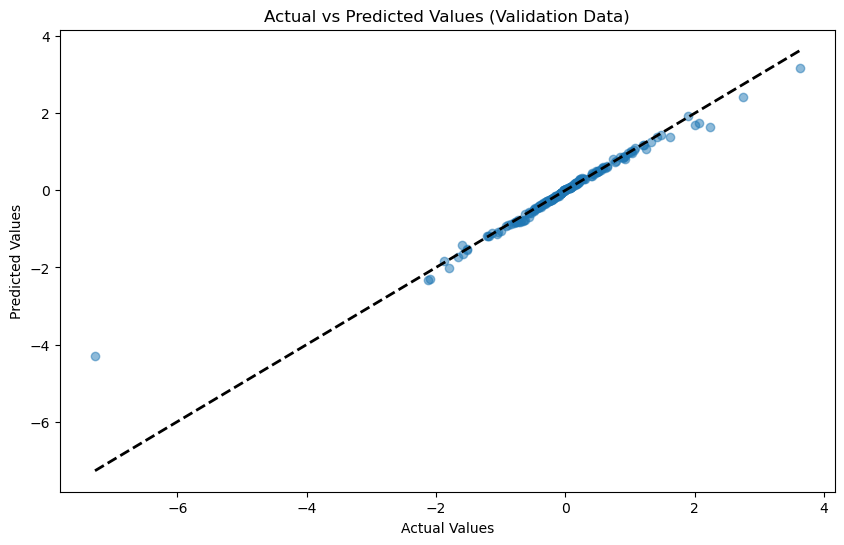

In [27]:
#Plotting of validation data

plt.figure(figsize=(10, 6))
plt.scatter(y_validation, y_validation_pred, alpha=0.5)
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Validation Data)')
plt.show()


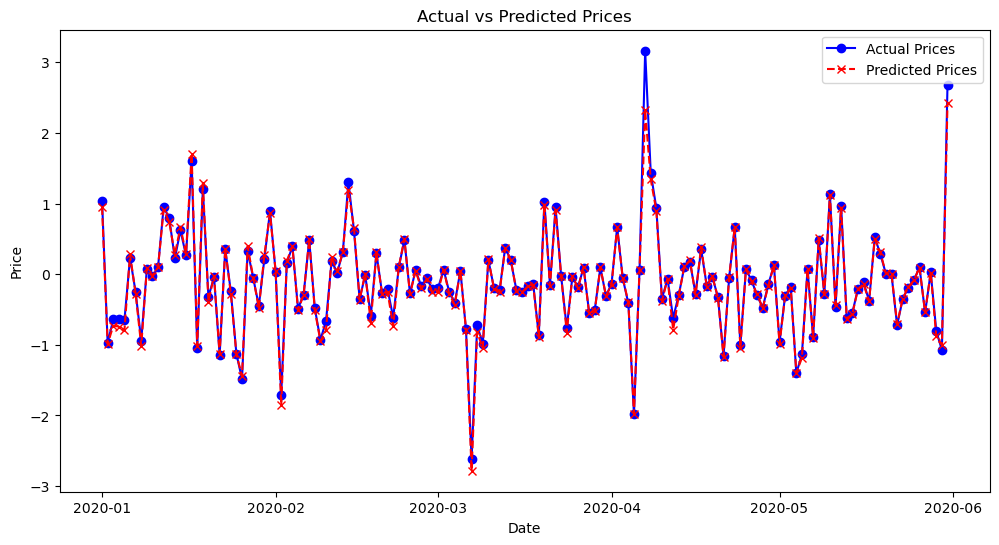

In [40]:
#Prediction with actuals

plt.figure(figsize=(12, 6))
plt.plot(test_datarf.index, y_test, label='Actual Prices', color='blue', marker='o')
plt.plot(test_datarf.index, y_test_pred, label='Predicted Prices', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [42]:
#Saving the model


dump(optimized_random_forest, '../Data/models_output/random_forest_logreturn.joblib')

['../Data/models_output/random_forest_logreturn.joblib']

# Random Forest 

Similar to Decision Tree model, The Random Forest regressor achieved an almost perfect fit on the **training dataset** with very low MSE and MAE, and an R^2 score close to 1. This indicates that the model was overfitted with the high probability. 
On the **testing dataset**, the model showed good performance with an MSE of 0.0074, MAE of 0.0365, and an R^2 score of approximately 0.986, indicating that the model has generalized well to unseen data.
The **validation dataset** showed slightly less performance compared to the testing dataset with an MSE of 0.0329, MAE of 0.0501, and an R^2 score of about 0.960.
The model identified Closing_Price_Diff (the feautre that was added for stationarity) as the most important feature, followed by other features like Bollinger Bands, 24h Low , and various lagged features. This suggests that the difference in closing price is the most significant predictor of future returns, according to the model.


#### Cross-validation Scores: 

Cross-validation resulted in a mean MSE of 0.3720 and a standard deviation of 0.3954, indicating some variability in model performance across different folds.

#### Hyperparameter Tuning:

Hyperparameter tuning identified that a max depth of 20, min samples leaf of 4, and n_estimators of 300 were the best parameters for the random forest model. Also the RFECV process was applied to select the most relevant features, potentially improving model robustness by removing irrelevant features.

After final model evaluation and tuning, the random forest showed strong performance on the test set with MSE and MAE values being low and an R^2 score indicating that the model explains a high percentage of the variance in the data. However, there is a slight decrease in performance when moving from the test to the validation set, as indicated by higher MSE and MAE values and a lower R^2 score on the validation set.

#### Cross-validation Scores after Hyperparameter Tuning

The cross-validated MAE, MSE, and R^2 scores provide a more generalized view of the model's performance across different subsets of the data. The high cross-validated R^2 score of approximately 0.921 indicates the model's robustness, despite variability in individual folds.

#### Summary


**The Random forest** regressor has demonstrated strong predictive capabilities in forecasting logarithmic returns of Bitcoin prices. It shows good generalization from the training set to unseen data, but there is room for improvement in its performance on the validation set. The feature importance results provide valuable insights into the drivers of Bitcoin's price movements, with price difference being a key factor.

The variability in cross-validation scores suggests that the model's performance could be sensitive to the specific subsets of the data used for training and validation. However, the model's ability to capture a significant amount of variance in the test data suggests it could be a useful tool for predicting Bitcoin prices.
